# Automatic Calibration Diagnosis: Interpreting Probability Integral Transform (PIT) Histograms

In [1]:
import functools
import math
import random

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib import gridspec
import pandas as pd
from scipy import stats
from sklearn.metrics.pairwise import euclidean_distances
import torch
import wandb

from calibration import data
from calibration import dist
from calibration import method
from calibration import pit
from calibration import plot

In [2]:
matplotlib.rcParams["font.family"] = "Times New Roman"
matplotlib.rcParams["font.size"] = 8
matplotlib.rcParams["axes.titlesize"] = 10
matplotlib.rcParams["figure.dpi"] = 300
PHI = (1 + math.sqrt(5)) / 2
WIDTH = 5.5
matplotlib.rcParams['figure.figsize'] = (WIDTH, (PHI - 1) * WIDTH)

In [3]:
def param2pdf(weight, mean, variance):
    return lambda x: dist.pdf_gaussian_mixture(x, weight, mean, variance)

def y2pdf(w, s, v1, v2):
    weight = torch.tensor([w, 1 - w])
    mean = torch.tensor([-s / 2, s / 2])
    variance = torch.tensor([v1, v2])
    return param2pdf(weight, mean, variance)

## PIT histogram

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


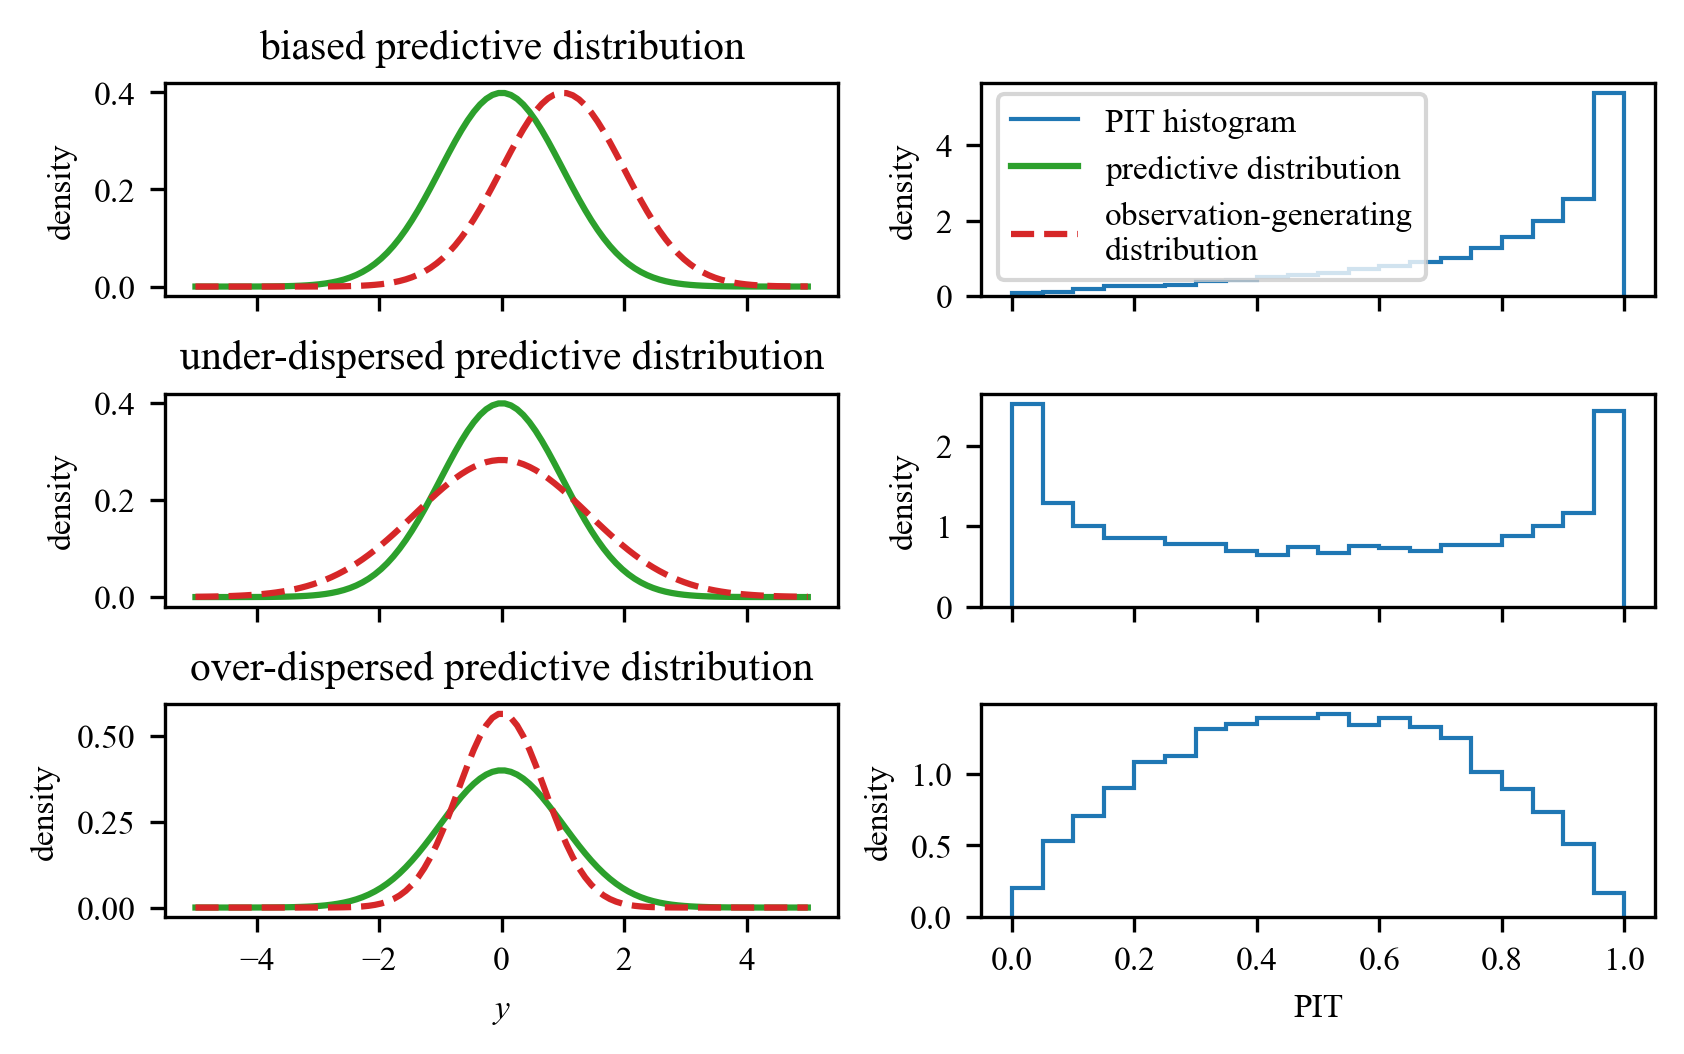

In [4]:
bias = (torch.tensor(1.0), torch.tensor(1.0), "biased")
under = (torch.tensor(0.0), torch.tensor(2.0), "under-dispersed")
over = (torch.tensor(0.0), torch.tensor(0.5), "over-dispersed")

_, axes = plt.subplots(nrows=3, ncols=2,
                       sharex="col", constrained_layout=True)
for ax, (mean, variance, label) in zip(axes, [bias, under, over]):
    ax[0].set_title(f"{label} predictive distribution")
    y = mean + torch.sqrt(variance) * torch.randn(pit.SAMPLES)
    handle_pred = plot.density(ax[0], dist.pdf_gaussian, color="C2")
    dist_obs = functools.partial(dist.pdf_gaussian, mean=mean, variance=variance)
    handle_obs = plot.density(ax[0], dist_obs, color="C3", linestyle="--")
    handle_pit = plot.pit_hist(ax[1], pit.pit_hist(pit.pit_gaussian(y)))
    ax[0].set_ylabel("density")
    ax[1].set_ylabel("density")
axes[2, 0].set_xlabel("y", style="italic")
axes[2, 1].set_xlabel("PIT")
axes[0, 1].legend([handle_pit, handle_pred, handle_obs],
                  ["PIT histogram",
                   "predictive distribution",
                   "observation-generating\ndistribution"])
plt.savefig("figures/types.eps")

## Automatically interpreting PIT histograms

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


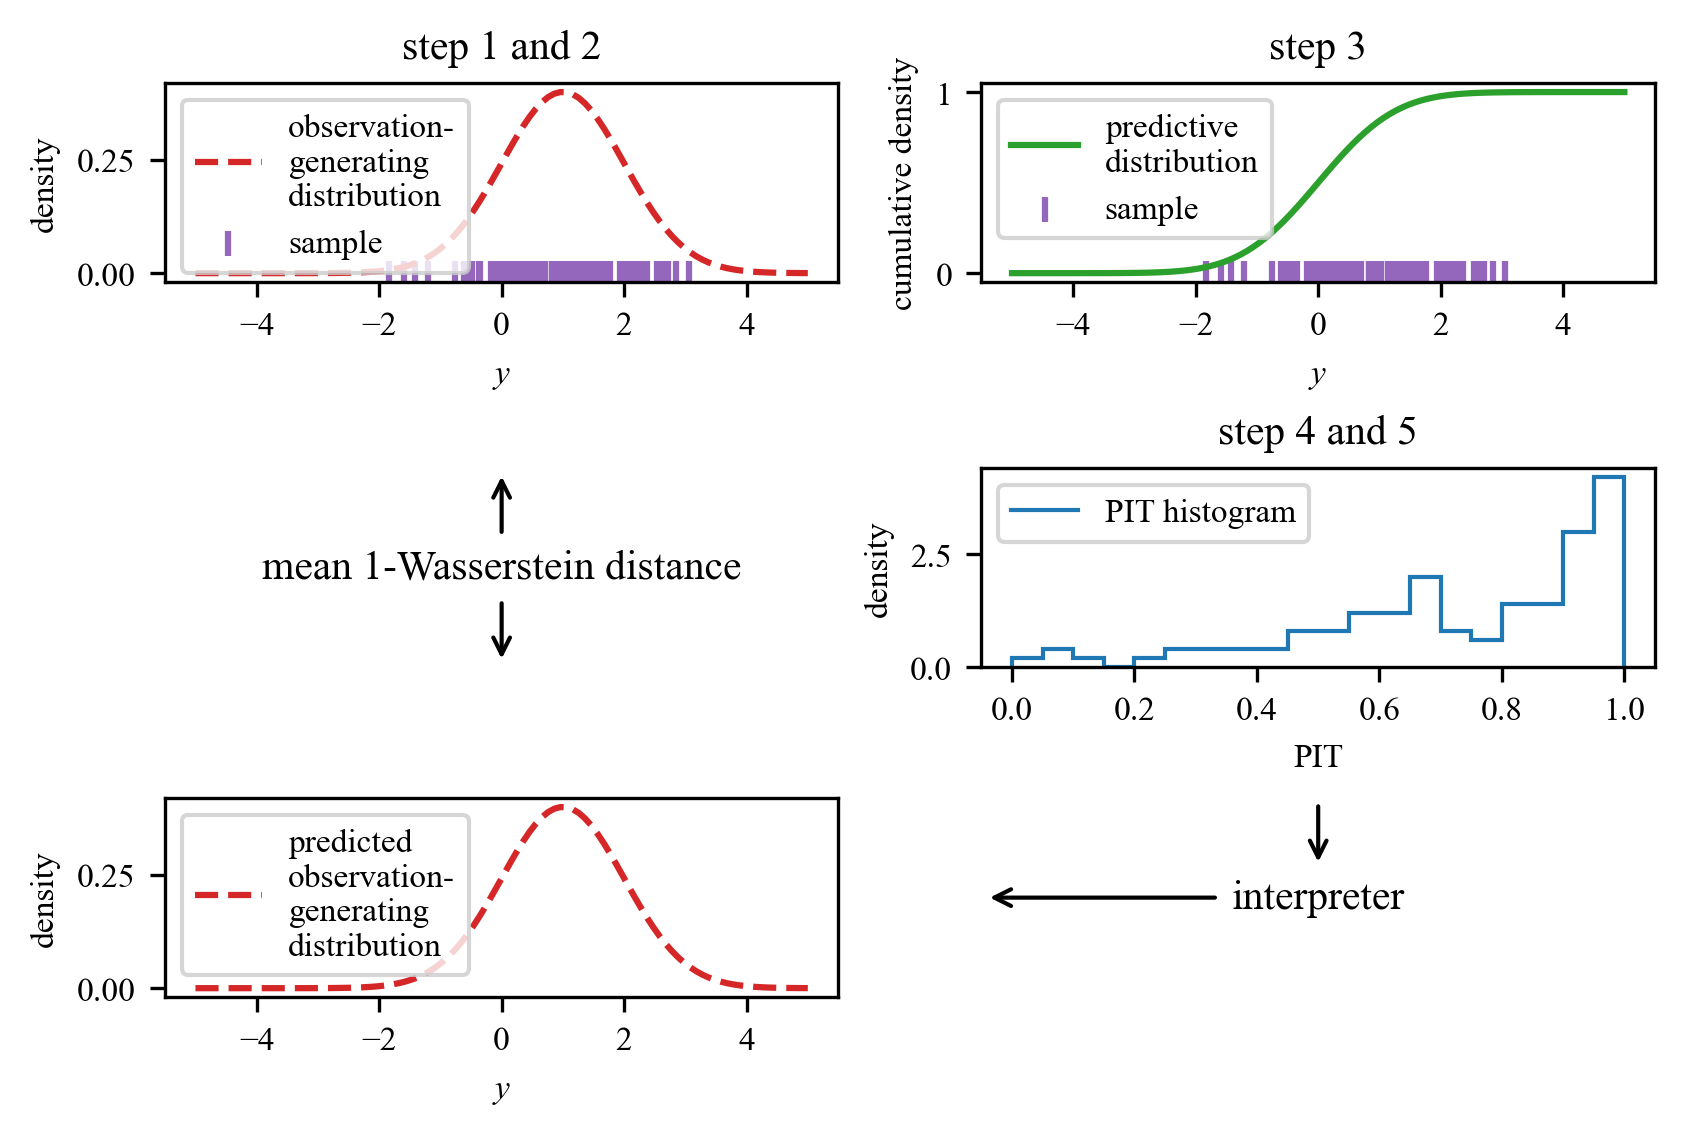

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2,
                         constrained_layout=True,
                         figsize=(WIDTH, (2 / 3) * WIDTH))
[[ax_obs, ax_pre], [ax_nll, ax_pit], [ax_pro, ax_int]] = axes

ax_obs.set_title("step 1 and 2")
mean = torch.tensor(1.0)
variance = torch.tensor(1.0)
pdf_obs = functools.partial(dist.pdf_gaussian, mean=mean, variance=variance)
plot.density(ax_obs, pdf_obs,
             color="C3", linestyle="--",
             label="observation-\ngenerating\ndistribution")
y = mean + torch.sqrt(variance) * torch.randn(100)
ax_obs.scatter(y, torch.zeros_like(y),
               color="C4", marker="|",
               label="sample")
ax_obs.legend(loc="upper left")
ax_obs.set_xlabel("y", style="italic")
ax_obs.set_ylabel("density")

ax_pre.set_title("step 3")
cdf_pre = dist.cdf_gaussian
plot.cumulative_density(ax_pre, cdf_pre,
                        color="C2",
                        label="predictive\ndistribution")
ax_pre.scatter(y, torch.zeros_like(y),
               color="C4", marker="|",
               label="sample")
ax_pre.legend(loc="upper left")
ax_pre.set_xlabel("y", style="italic")
ax_pre.set_ylabel("cumulative density")

ax_pit.set_title("step 4 and 5")
plot.pit_hist(ax_pit, pit.pit_hist(pit.pit_gaussian(y)),
              label="PIT histogram")
ax_pit.legend(loc="upper left")
ax_pit.set_xlabel("PIT")
ax_pit.set_ylabel("density")

ax_int.set_axis_off()
textstyle = dict(va="center", ha="center", fontsize=10)
ax_int.annotate("interpreter",
                xy=(0.5, 1), xycoords="data",
                xytext=(0.5, 0.5), textcoords="data",
                arrowprops=dict(arrowstyle="<-"),
                **textstyle)
ax_int.annotate("interpreter",
                xy=(0, 0.5), xycoords="data",
                xytext=(0.5, 0.5), textcoords="data",
                arrowprops=dict(arrowstyle="->"),
                **textstyle, alpha=0.0)

plot.density(ax_pro, pdf_obs,
             color="C3", linestyle="--",
             label="predicted\nobservation-\ngenerating\ndistribution")
ax_pro.legend(loc="upper left")
ax_pro.set_xlabel("y", style="italic")
ax_pro.set_ylabel("density")

ax_nll.set_axis_off()
ax_nll.annotate("mean 1-Wasserstein distance",
                xy=(0.5, 1), xycoords="data",
                xytext=(0.5, 0.5), textcoords="data",
                arrowprops=dict(arrowstyle="->"),
                **textstyle)
ax_nll.annotate("mean 1-Wasserstein distance",
                xy=(0.5, 0), xycoords="data",
                xytext=(0.5, 0.5), textcoords="data",
                arrowprops=dict(arrowstyle="->"),
                **textstyle, alpha=0.0)

plt.savefig("figures/concept.eps")

## Interpreter

In [6]:
checkpoint = torch.load("models/legendary-pine-75.pt")
hyperparams = checkpoint["hyperparams"]
interpreter = method.MDN(inputs=hyperparams["bins"],
                neurons=hyperparams["neurons"],
                components=hyperparams["components"])
interpreter.load_state_dict(checkpoint["model_state_dict"])
interpreter

MDN(
  (linear1): Linear(in_features=20, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=15, bias=True)
)

## Synthetic data set

In [7]:
TESTS = 1000
torch.manual_seed(78)
testset = pit.PITDataset(TESTS)

In [8]:
refset = pit.PITReference()
len(refset)

625

In [9]:
pred_mdn = method.predict(interpreter, testset.histograms)

In [10]:
random.seed(54)
random.sample(range(len(testset)), k=3)

[935, 140, 449]

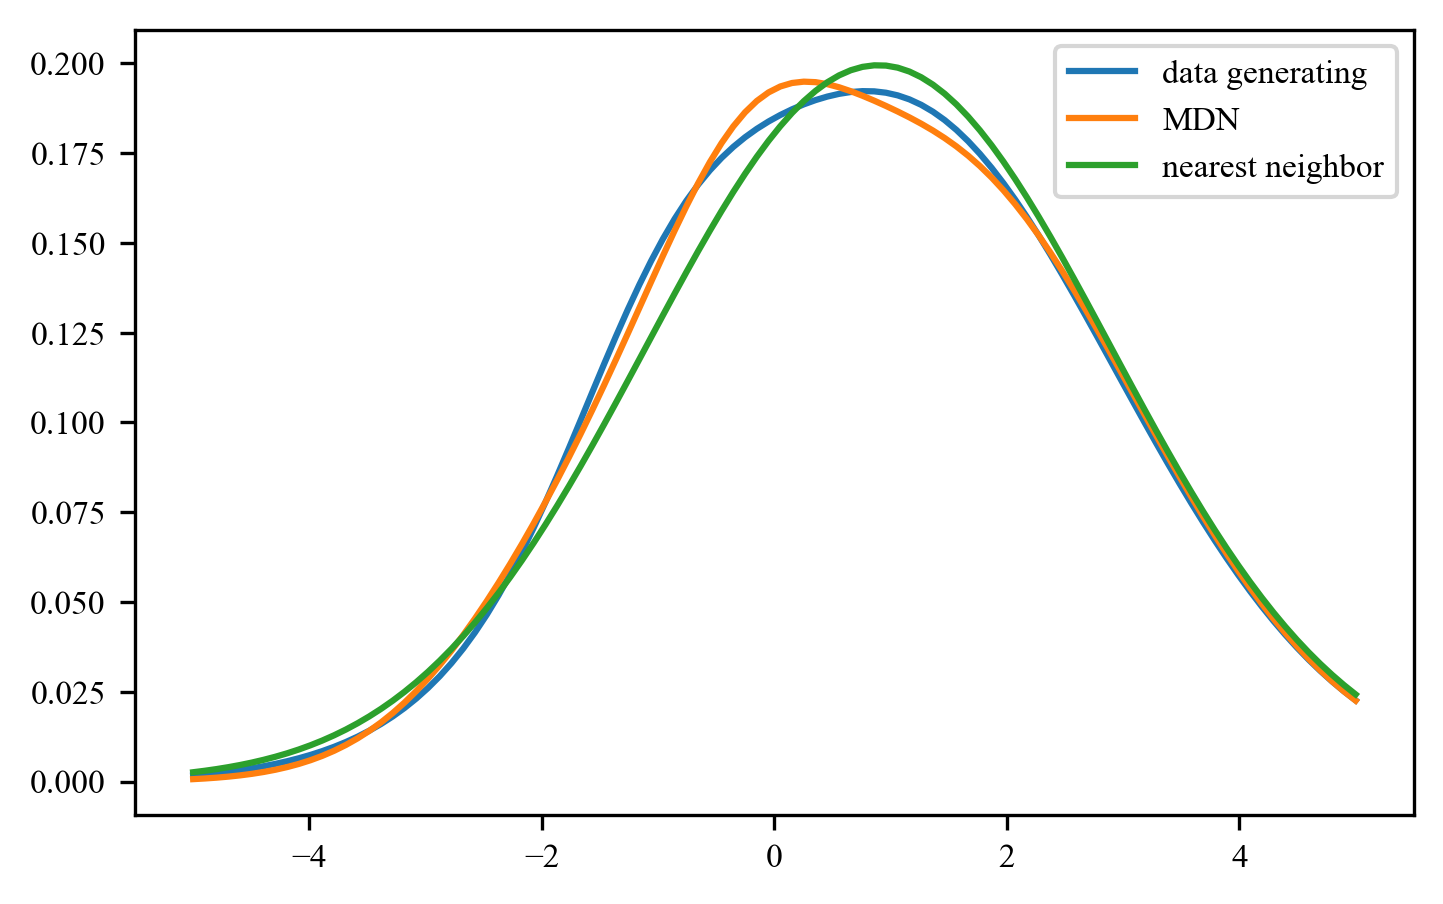

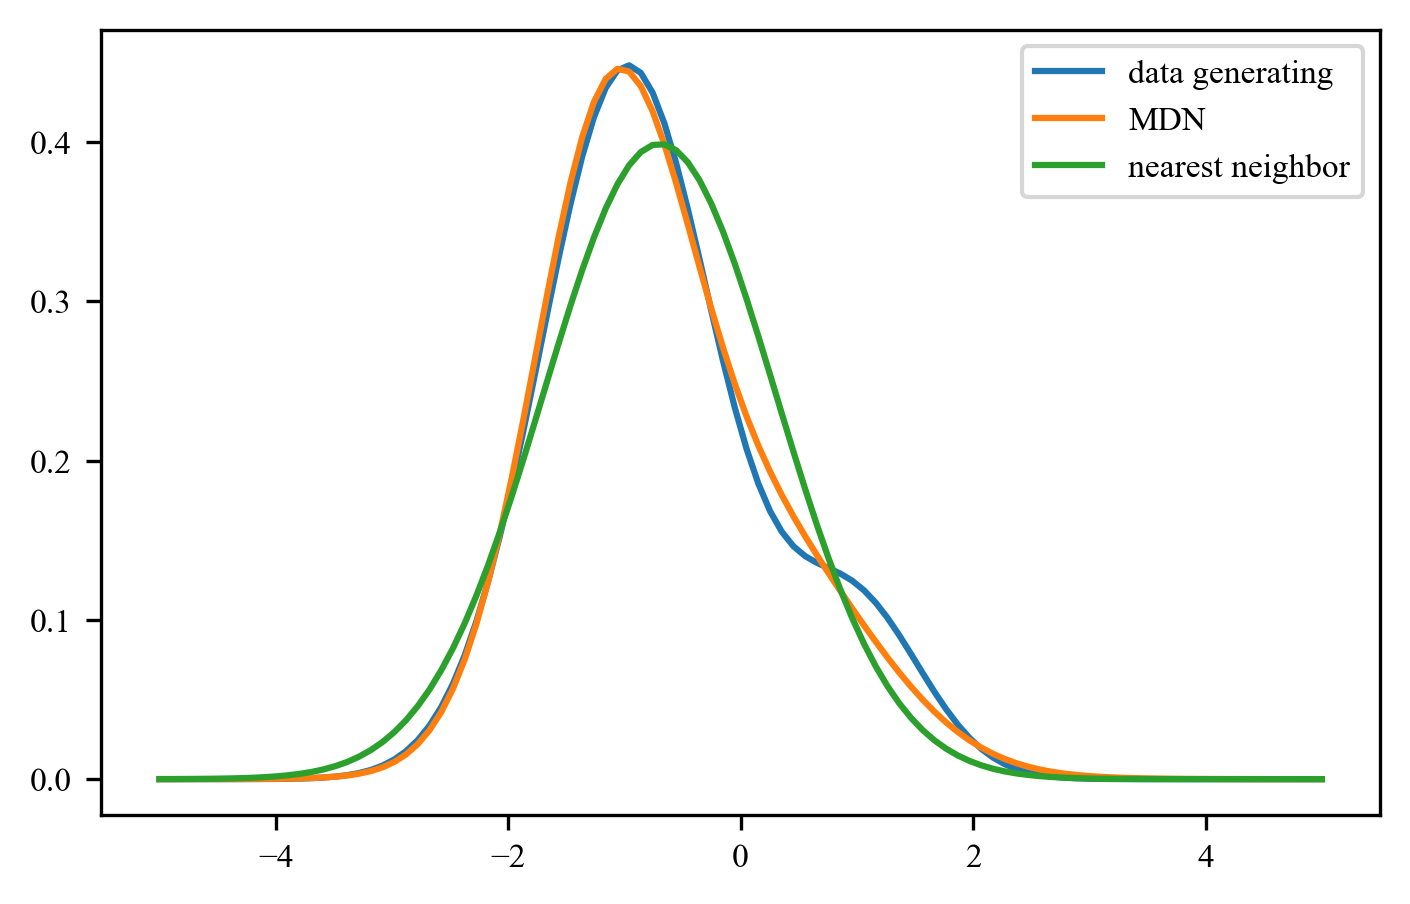

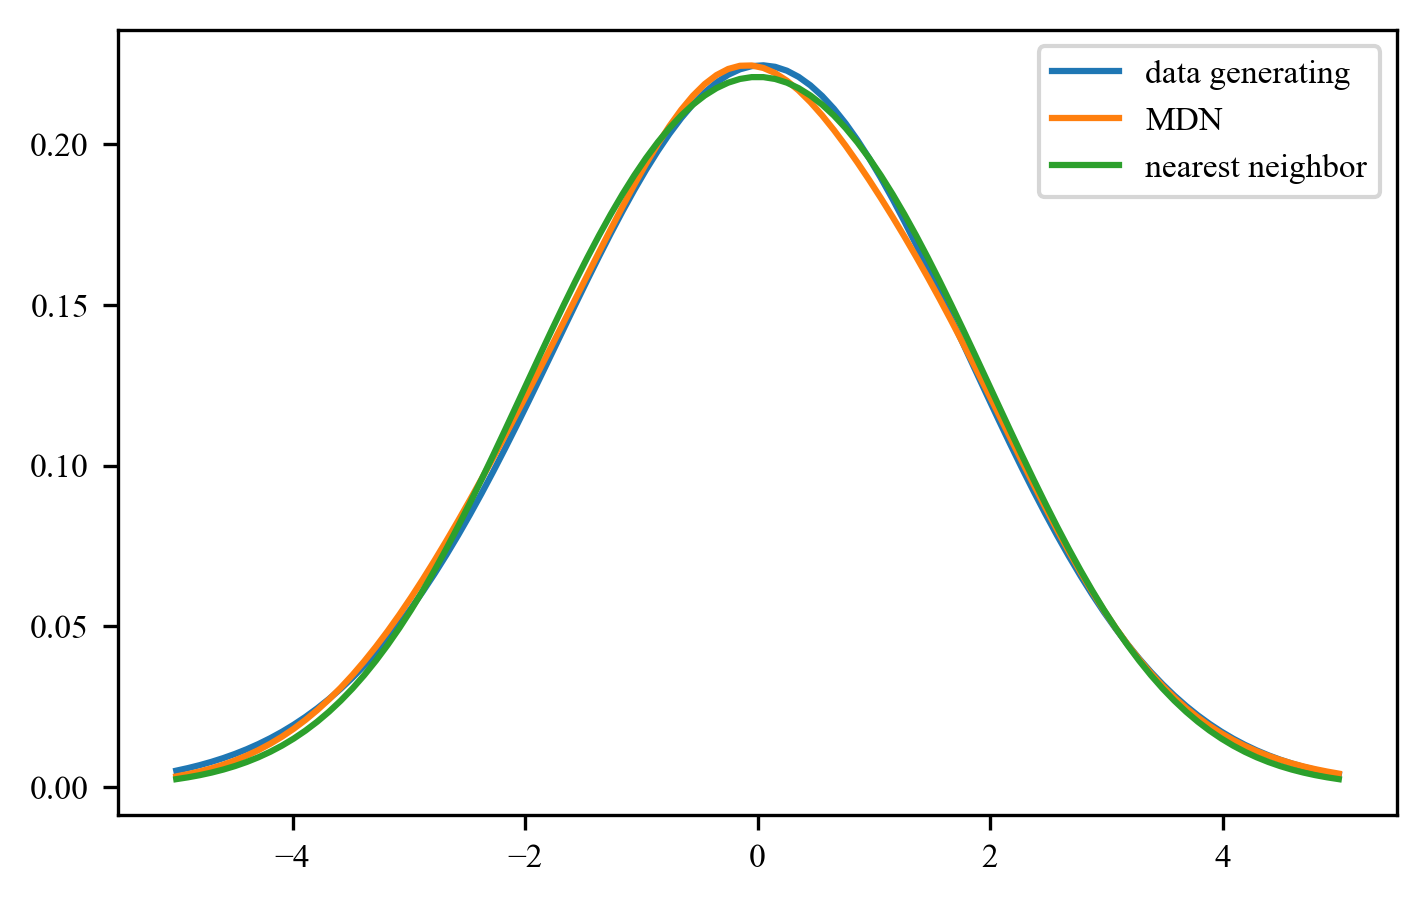

In [11]:
distances = euclidean_distances(testset.histograms, refset.histograms)
js = distances.argmin(axis=1)
random.seed(54)
for i in random.sample(range(len(testset)), k=3):
    y = testset.parameters[i]
    weight = pred_mdn[0][i]
    mean = pred_mdn[1][i]
    variance = pred_mdn[2][i]
    neighbour = refset.parameters[js][i]
    _, ax = plt.subplots()
    plot.density(ax, y2pdf(*y), label="data generating")
    plot.density(ax, param2pdf(weight, mean, variance), label="MDN")
    plot.density(ax, y2pdf(*neighbour), label="nearest neighbor")
    ax.legend()
    plt.show()
    plt.close()

In [12]:
wasserstein_mdn = method.wasserstein_loss(testset.parameters, *pred_mdn).mean()
wasserstein_mdn.item()

0.24707616865634918

In [13]:
steps = range(5, 18)
wasserstein_neighbour = []
for s in steps:
    refset = pit.PITReference(steps=s)
    distances = euclidean_distances(testset.histograms, refset.histograms)
    js = distances.argmin(axis=1)
    neighbour = refset.parameters[js]
    weight = torch.stack([neighbour[:, 0], 1 - neighbour[:, 0]], dim=1)
    mean = torch.stack((-neighbour[:, 1] / 2, neighbour[:, 1] / 2), dim=1)
    variance = neighbour[:, 2:]
    wasserstein = method.wasserstein_loss(testset.parameters, weight, mean, variance)
    wasserstein_neighbour.append(wasserstein.mean().item())
    print(f"{s:2d} {wasserstein_neighbour[-1]:f} {s ** 4}")

 5 0.945503 625
 6 0.765510 1296
 7 0.630919 2401
 8 0.560525 4096
 9 0.505124 6561
10 0.458255 10000
11 0.425789 14641
12 0.400632 20736
13 0.379489 28561
14 0.361142 38416
15 0.348435 50625
16 0.341031 65536
17 0.333784 83521


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


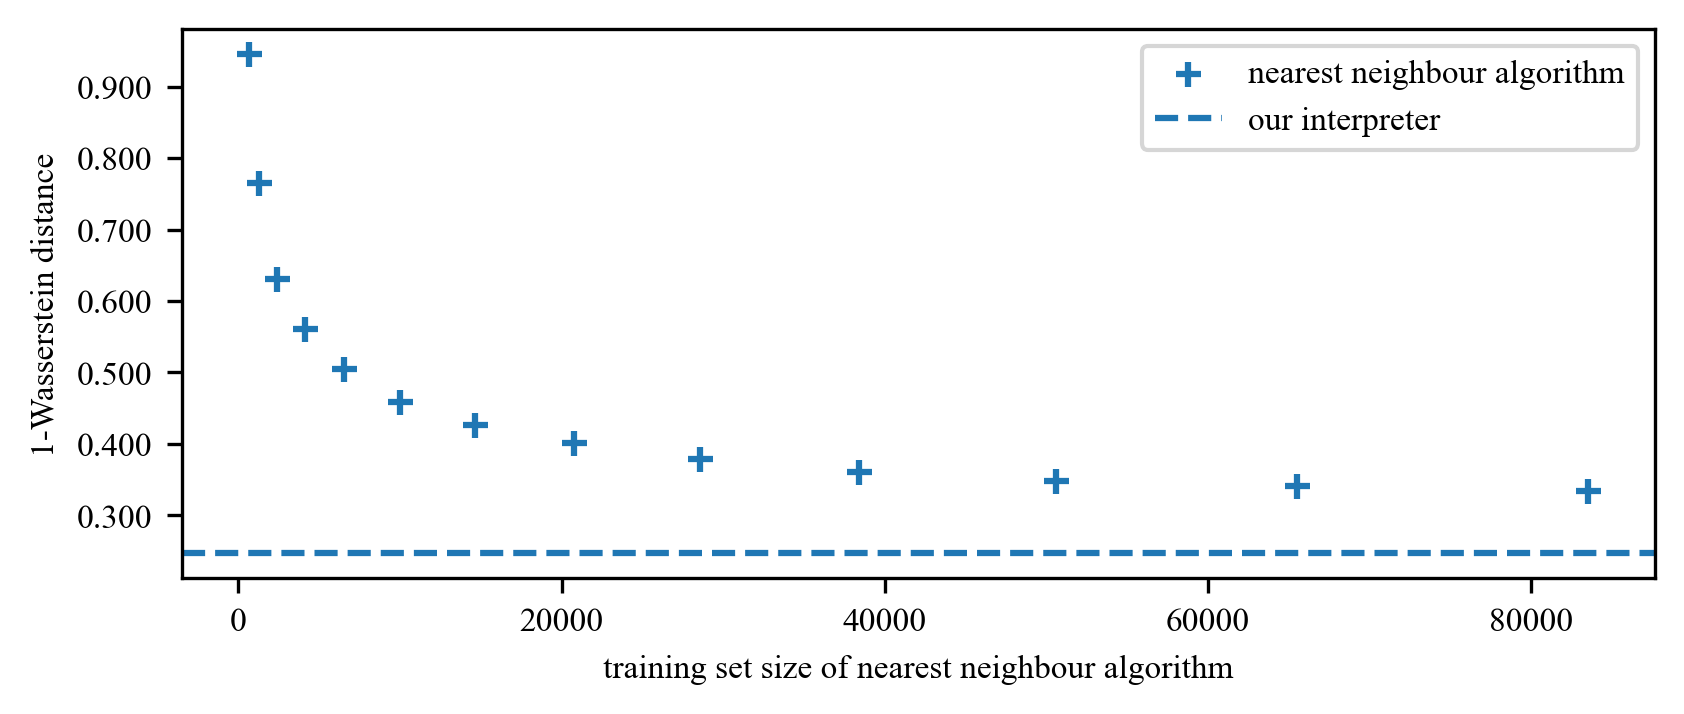

In [14]:
_, ax = plt.subplots(figsize=(5.5, (2 / 3) * (PHI - 1) * 5.5), constrained_layout=True)
size = [s ** 4 for s in steps]
ax.scatter(size, wasserstein_neighbour, marker="+", label="nearest neighbour algorithm")
ax.axhline(round(wasserstein_mdn.item(), 3), ls="--", label="our interpreter")
ax.set_xlabel("training set size of nearest neighbour algorithm")
ax.set_ylabel("1-Wasserstein distance")
ax.legend()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.3f}"))
plt.savefig("figures/neighbour.eps")

In [15]:
df = pd.DataFrame.from_dict({"steps": steps,
                             "size": size,
                             "wasserstein": wasserstein_neighbour})
df = df.set_index("steps")
df

,size,wasserstein
steps,,
5,625,0.945503
6,1296,0.765510
7,2401,0.630919
8,4096,0.560525
9,6561,0.505124
10,10000,0.458255
11,14641,0.425789
12,20736,0.400632
13,28561,0.379489


## Uniform PIT histogram

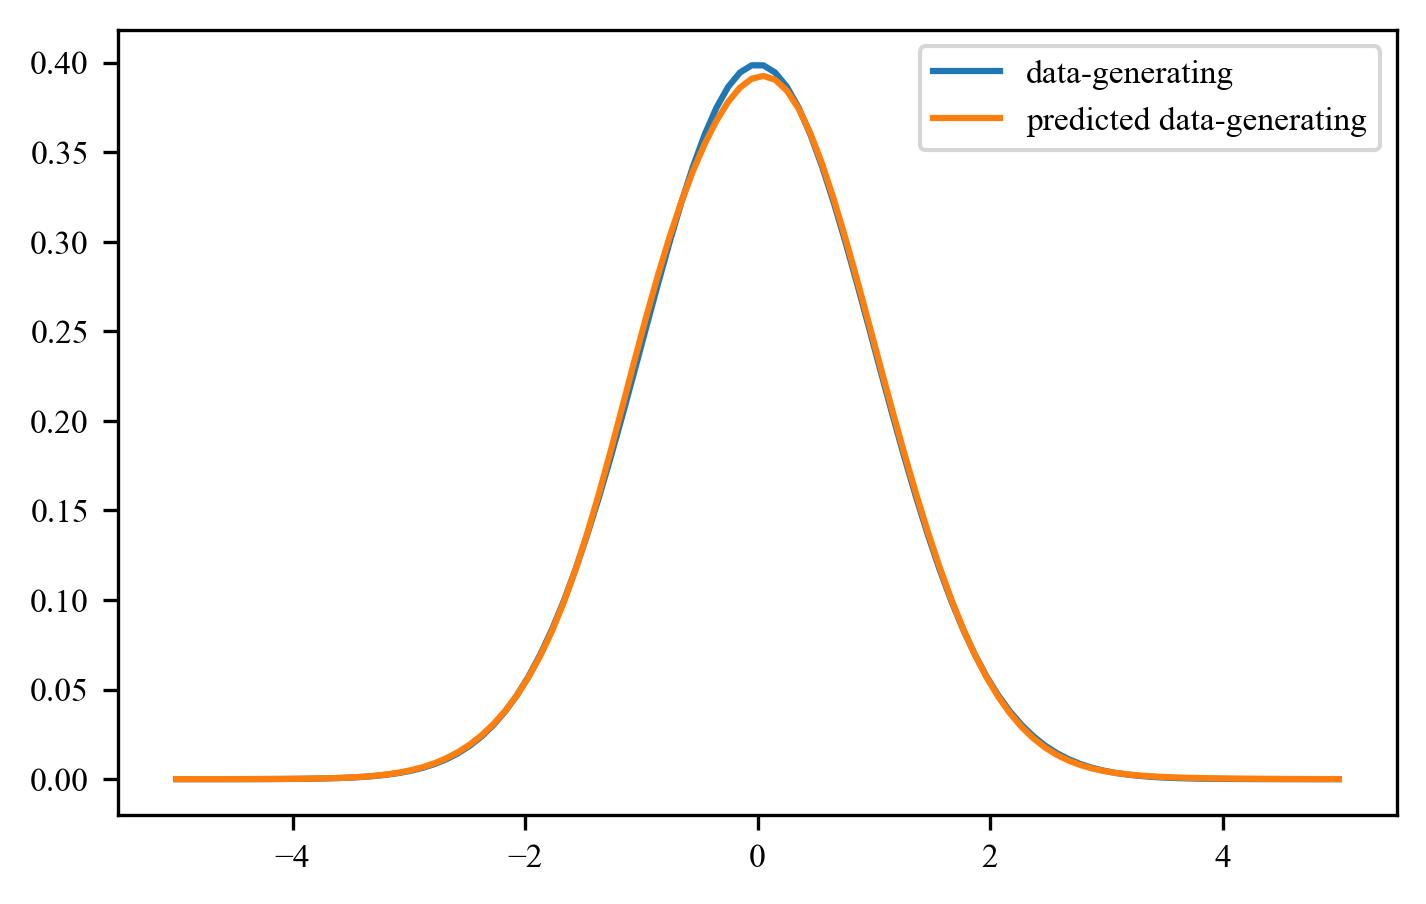

In [16]:
pit_hist_uniform = torch.full((pit.BINS, ), 1.0)
pred_uniform = method.predict(interpreter, pit_hist_uniform)
_, ax = plt.subplots()
plot.density(ax, dist.pdf_gaussian, label="data-generating")
plot.density(ax, param2pdf(*pred_uniform), label="predicted data-generating")
ax.legend()

## UCI ML repository data sets

In [17]:
def load_model(modelfile, Model, keys):
    checkpoint = torch.load(modelfile)
    hyperparams = checkpoint["hyperparams"]
    model = Model(*[hyperparams[k] for k in ("inputs", "neurons") + keys])
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

def load_mdn(modelfile):
    return load_model(modelfile, method.MDN, ("components", ))

def load_dn(modelfile):
    return load_mdn(modelfile)

def load_de(modelfile):
    return load_model(modelfile, method.DE, ("members", ))

def plot_interpretation(ax, interpretation):
    density_predictive = plot.density(ax, dist.pdf_gaussian, color="C2")
    density_interpret = plot.density(ax, param2pdf(*interpretation), color="C3", ls="--")
    return density_predictive, density_interpret

def pit_hist(model, dataset):
    alpha, mu, sigma = method.predict(model, dataset.X)
    pit_values = pit.pit_gaussian_mixture(dataset.y, alpha, mu, sigma)
    return pit.pit_hist(pit_values)

def diagnose(pit_hist, ax_pit, ax_dist, interpreter=interpreter):
    interpretation = method.predict(interpreter, pit_hist)
    pit_hist_interpreter = pit.pit_hist(pit.pit_gaussian(dist.sample_gaussian_mixture(*interpretation)))
    hist_true = plot.pit_hist(ax_pit, pit_hist, fill=True)
    hist_pred = plot.pit_hist(ax_pit, pit_hist_interpreter)
    density_predictive, density_interpret = plot_interpretation(ax_dist, interpretation)
    return hist_true, hist_pred, density_predictive, density_interpret

def visualise(pit_hist_dn, pit_hist_de, pit_hist_mdn):
    _, axes = plt.subplots(3, 2,
                           constrained_layout=True,
                           figsize=(WIDTH, (PHI - 1) * WIDTH))
    axes[0, 0].set_title("density network")
    axes[1, 0].set_title("deep ensemble")
    axes[2, 0].set_title("mixture density network")
    _, hist_pred, density_pred, density_interpret = diagnose(pit_hist_dn, axes[0, 0], axes[0, 1])
    print(density_interpret)
    diagnose(pit_hist_de, axes[1, 0], axes[1, 1])
    hist_mdn = plot.pit_hist(axes[2, 0], pit_hist_mdn, fill=True)
    axes[0, 0].set_xticklabels([])
    axes[0, 1].set_xticklabels([])
    axes[2, 1].set_axis_off()
    axes[2, 1].legend([hist_mdn, hist_pred, density_pred, density_interpret],
                      ["true PIT histogram",
                       "predicted PIT histogram",
                       "predictive distribution",
                       "predicted observation-generating distribution"],
                      loc="center")
    axes[1, 0].set_xlabel("PIT")
    axes[2, 0].set_xlabel("PIT")
    axes[1, 1].set_xlabel("y", style="italic")
    for i in range(3):
        axes[i, 0].set_ylabel("density")
        axes[i, 1].set_ylabel("density")

### Metrics

In [18]:
api = wandb.Api()
runs = api.runs("calibration")

keys = ["dataname", "method", "seed", "neurons"]
dicts, names = [], []
for run in runs:
    try:
        dictionary = {k: run.config[k] for k in keys}
        dictionary["nll"] = run.summary["test.nll"]
        dictionary["crps"] = run.summary["test.crps"]
    except KeyError:
        continue
    dicts.append(dictionary)
    names.append(run.name)

df = pd.DataFrame(data=dicts, index=names)
gdf = df.groupby(["dataname", "method"])
df

,dataname,method,seed,neurons,nll,crps
whole-planet-49,protein,de,15,100,2.688056,2.210364
colorful-pyramid-48,protein,de,9,100,2.703884,2.099502
worthy-blaze-46,protein,de,8,100,2.682899,2.274802
sleek-wood-46,protein,de,7,100,2.585679,2.193159
peachy-sponge-45,year,de,15,100,3.365911,4.296823
earthy-shape-44,year,de,9,100,3.375157,4.340910
fanciful-plasma-43,year,de,8,100,3.355052,4.252754
clear-sea-42,year,de,7,100,3.372073,4.299245
desert-breeze-41,year,mdn,15,100,3.094955,4.036980
silvery-universe-40,year,mdn,9,100,3.091838,4.048255


In [19]:
gdf["nll"].agg(["mean", "sem"])

mean       sem
dataname method                    
power    de      2.808961  0.016763
         dn      2.794552  0.017980
         mdn     2.672990  0.022673
protein  de      2.674714  0.022905
         dn      2.804612  0.039376
         mdn     2.085908  0.016889
year     de      3.366982  0.003437
         dn      3.372904  0.003265
         mdn     3.093512  0.001768

In [20]:
gdf["crps"].agg(["mean", "sem"])

mean       sem
dataname method                    
power    de      2.125439  0.031547
         dn      2.175104  0.030190
         mdn     2.092784  0.042207
protein  de      2.196378  0.028107
         dn      2.341886  0.024816
         mdn     1.939665  0.019076
year     de      4.293765  0.014421
         dn      4.322462  0.013480
         mdn     4.039576  0.007017

### Year

In [21]:
_, _, yearset = data.split(*data.year(), seed=4)

In [22]:
pit_hist_dn_year = pit_hist(load_dn("models/rich-dragon-8.pt"), yearset)
pit_hist_de_year = pit_hist(load_de("models/generous-valley-7.pt"), yearset)
pit_hist_mdn_year = pit_hist(load_mdn("models/chocolate-sound-9.pt"), yearset)

Line2D(_child1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


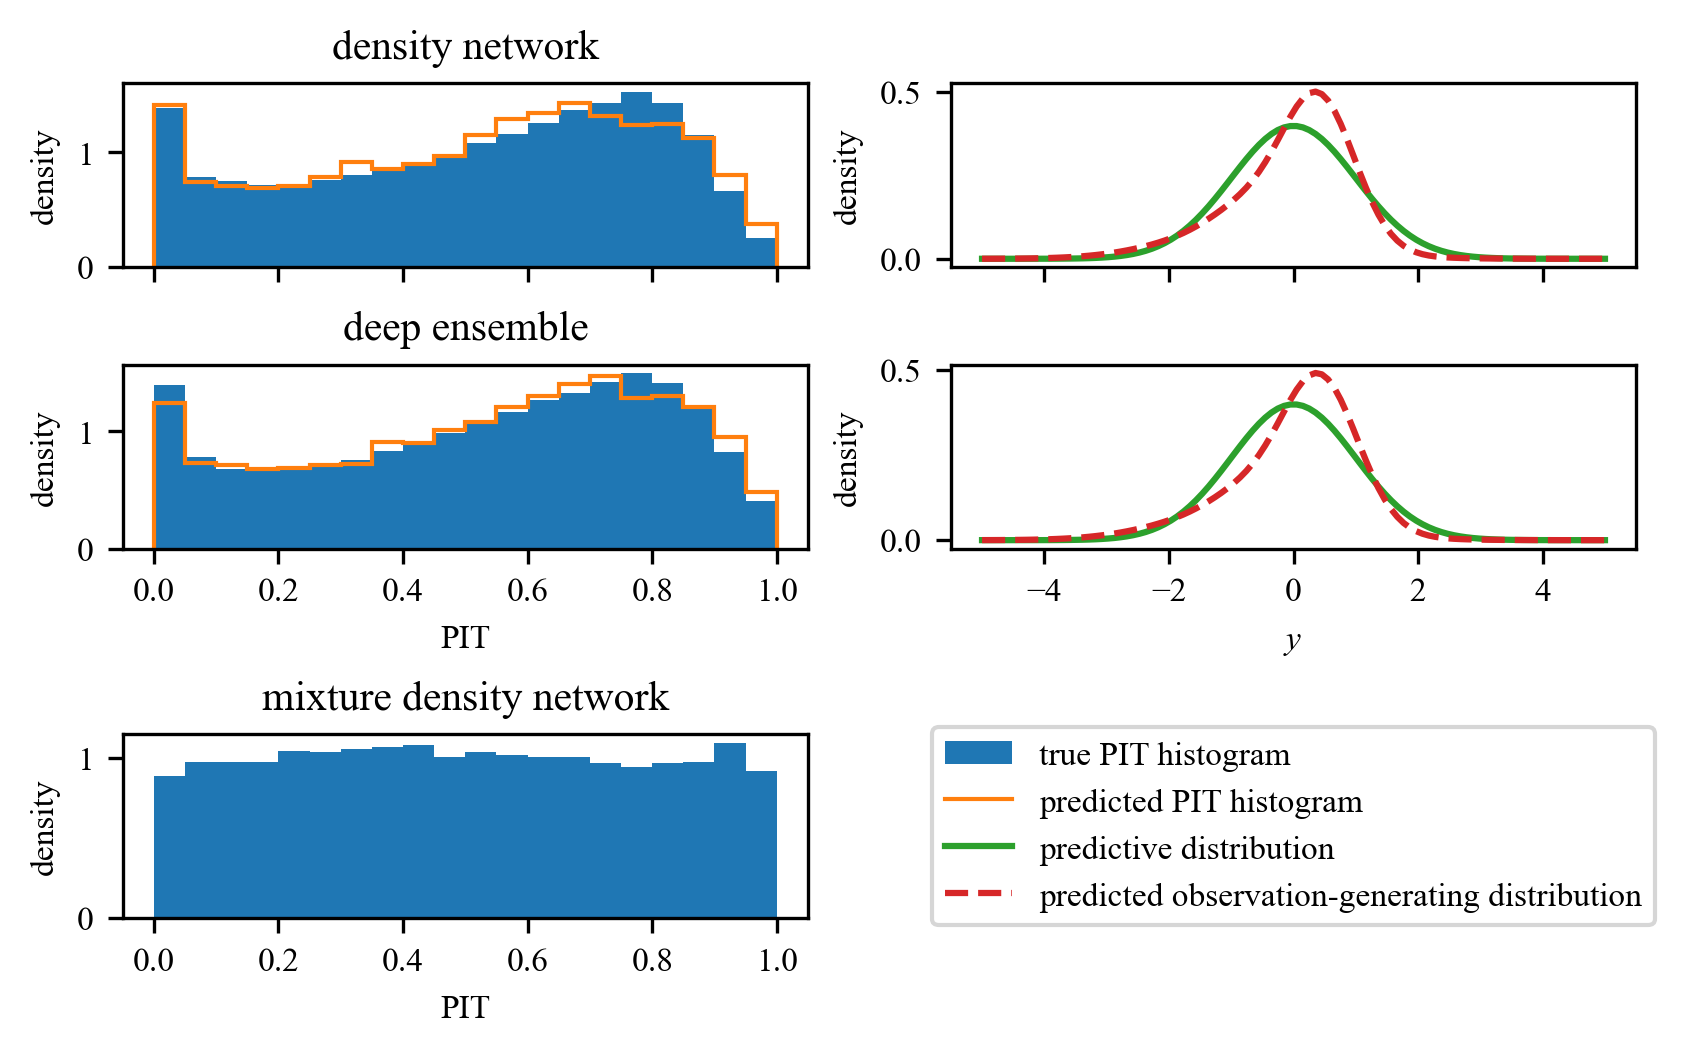

In [23]:
visualise(pit_hist_dn_year, pit_hist_de_year, pit_hist_mdn_year)
plt.savefig("figures/year.eps")

### Protein

In [24]:
_, _, proteinset = data.split(*data.protein(), seed=4)

In [25]:
pit_hist_dn_protein = pit_hist(load_dn("models/super-durian-4.pt"), proteinset)
pit_hist_de_protein = pit_hist(load_de("models/golden-snow-6.pt"), proteinset)
pit_hist_mdn_protein = pit_hist(load_mdn("models/lucky-moon-5.pt"), proteinset)

Line2D(_child1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


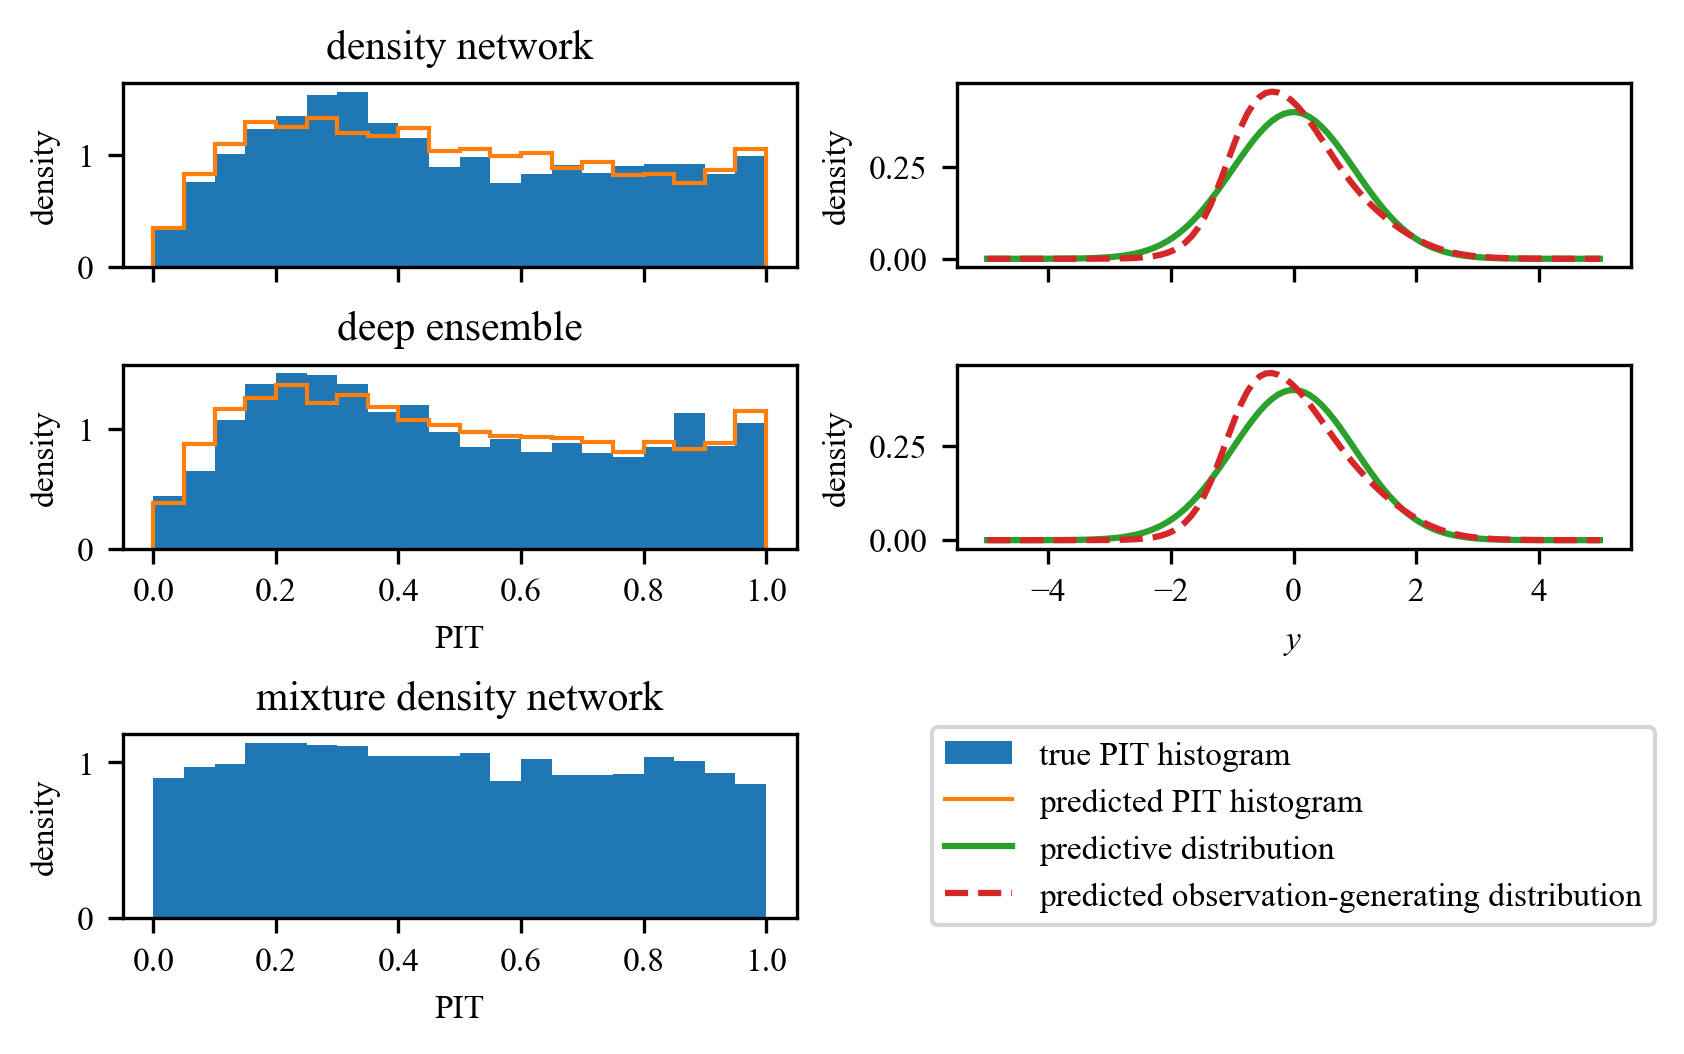

In [26]:
visualise(pit_hist_dn_protein, pit_hist_de_protein, pit_hist_mdn_protein)
plt.savefig("figures/protein.eps")

### Power

In [27]:
_, _, powerset = data.split(*data.power(), seed=4)

In [28]:
pit_hist_dn_power = pit_hist(load_dn("models/polished-star-1.pt"), powerset)
pit_hist_de_power = pit_hist(load_de("models/elated-surf-3.pt"), powerset)
pit_hist_mdn_power = pit_hist(load_mdn("models/effortless-firefly-2.pt"), powerset)

Line2D(_child1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


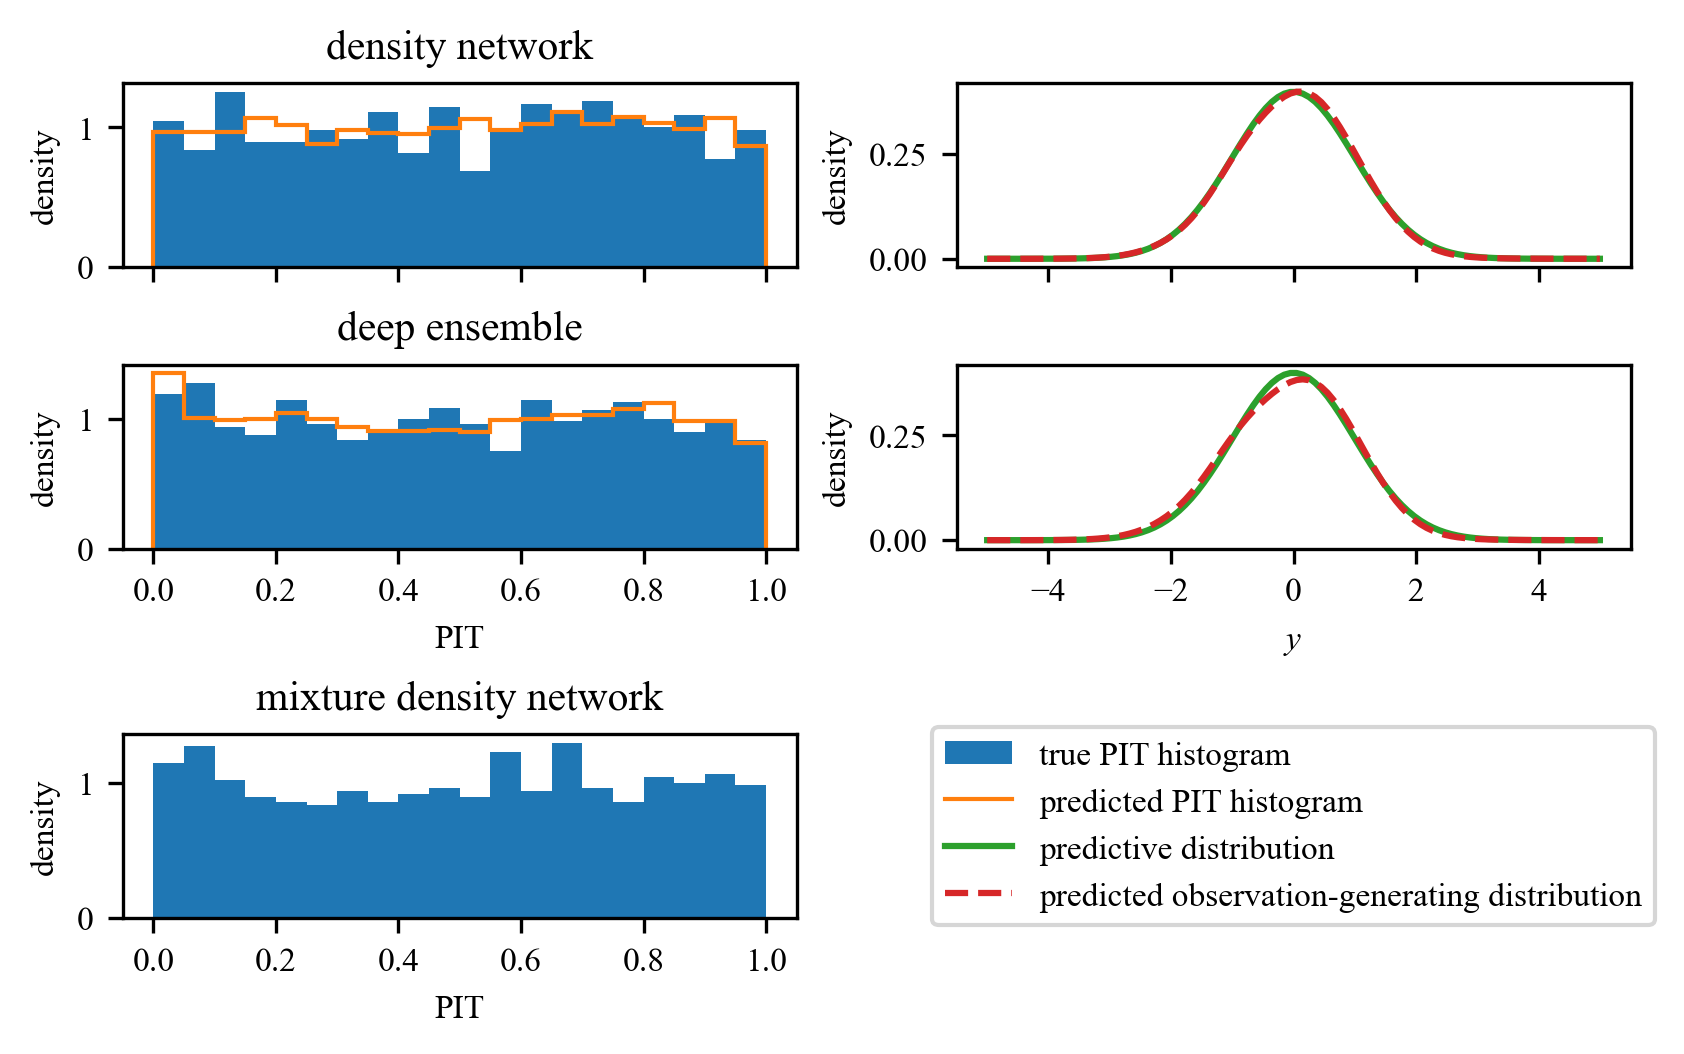

In [29]:
visualise(pit_hist_dn_power, pit_hist_de_power, pit_hist_mdn_power)
plt.savefig("figures/power.eps")